# Исследование приливов Ирландии

# <a name="0.0"></a>Содержание:
* [Описание признаков](#1.)
* [Импорт библиотек](#2.)
* [Общая информация](#3.)
* [Исследовательский анализ](#4.)
    - [Анализ характера приливов](#4.1.)
    - [Анализ зависимости от географического положения](#4.2.)
    - [Анализ тенденций максимальной высоты приливной волны с течением времени](#4.3.)
* [Вывод](#5.)

<a name="1."></a>
## Описание признаков
<font size="2">([к содержанию](#0.0))</font>

- **time:** Временная метка, указывающая на дату и время в формате UTC;
- **longitude:** Долгота местоположения приливной станции. Долгота измеряется в градусах на восток от Гринвичского меридиана (0 градусов долготы);
- **latitude:** Широта местоположения приливной станции. Широта измеряется в градусах на север от экватора (0 градусов широты);
- **stationID:** Идентификатор приливной станции, где проводятся наблюдения или измерения;
- **Water_Level:** Измерение уровня воды в метрах;
- **Water_Level_ODM:** Значение уровня воды с учетом относительной высоты над уровнем моря (ODM - Ordnance Datum), таким образом, это значение может быть отрицательным или положительным, в зависимости от того, выше или ниже уровня моря находится местоположение.

<a name="2."></a>
## Импорт библиотек
<font size="2">([к содержанию](#0.0))</font>

In [1]:
# основные библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# карта
import folium
from folium import plugins

# анализ
import plotly.express as px
from scipy.signal import argrelextrema

# игнорировать предупреждения о производительности
import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

### Загрузка данных

In [2]:
try:
    data = pd.read_csv('/Users/pavelspirin/ODS/Pet_projects/Tide_prediction/tide_data.csv', low_memory=False)
    print('File load: Success through desktop computer')
except:
    print('File load: Failed')

File load: Success through desktop computer


<a name="3."></a>
## Общая информация
<font size="2">([к содержанию](#0.0))</font>

In [3]:
data.head()

,time,longitude,latitude,stationID,Water_Level,Water_Level_ODM
0,UTC,degrees_east,degrees_north,NaN,metres,metres
1,2017-01-01T00:10:00Z,-10.101596,53.95219,Achill_Island_MODELLED,1.34,-1.23
2,2017-01-01T00:20:00Z,-10.101596,53.95219,Achill_Island_MODELLED,1.3,-1.27
3,2017-01-01T00:30:00Z,-10.101596,53.95219,Achill_Island_MODELLED,1.26,-1.31
4,2017-01-01T00:40:00Z,-10.101596,53.95219,Achill_Island_MODELLED,1.23,-1.34


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6885394 entries, 0 to 6885393
Data columns (total 6 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   time             object
 1   longitude        object
 2   latitude         object
 3   stationID        object
 4   Water_Level      object
 5   Water_Level_ODM  object
dtypes: object(6)
memory usage: 315.2+ MB


Удалим первую строку (строку с индексом 0) из датасета

In [5]:
data = data.drop(0)

Изменим формат данных для всех признаков

In [6]:
data['time'] = pd.to_datetime(data['time'])
data['longitude'] = data['longitude'].astype(float)
data['latitude'] = data['latitude'].astype(float)
data['Water_Level'] = data['Water_Level'].astype(float)
data['Water_Level_ODM'] = data['Water_Level_ODM'].astype(float)
data['stationID'] = data['stationID'].astype(str)

In [7]:
# Изменим название признаков
data.columns = ['time', 'longitude', 'latitude', 'station_id', 'water_level', 'water_level_odm']

Найдем названия уникальных приливных станций

In [8]:
data.station_id.unique()

array(['Achill_Island_MODELLED', 'Aranmore', 'Arklow_MODELLED',
       'Ballycotton', 'Ballyglass', 'Bray_Harbour_MODELLED',
       'Carrigaholt_MODELLED', 'Castletownbere', 'Clare_Island_MODELLED',
       'Crosshaven_MODELLED', 'Dingle_Harbour_MODELLED', 'Dublin_Port',
       'Dundalk', 'Dungarvan_MODELLED', 'Dunmore_East', 'Fenit_MODELLED',
       'Galway_Port', 'Howth', 'Inishmore', 'Killary_Harbour_MODELLED',
       'Killybegs', 'Kinsale_MODELLED', 'Kish_Bank_Lighthouse',
       'Lahinch_MODELLED', 'Letterfrack_MODELLED', 'Malin_Head',
       'Rosslare_Port_MODELLED', 'Skerries', 'Sligo',
       'Tory_Island_MODELLED', 'Union_Hall_MODELLED', 'Wexford',
       'Wicklow_MODELLED'], dtype=object)

Найдем координаты всех приливных станций и отобразим их на карте

In [9]:
coordinates = data[['longitude', 'latitude', 'station_id']].drop_duplicates()

In [10]:
# Создадим карту с центром на средних значениях широты и долготы
map_center = [coordinates['latitude'].mean(), coordinates['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=7)

# Добавим маркеры для каждой координаты
for index, row in coordinates.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['station_id']).add_to(mymap)

mymap

<a name="4."></a>
## Исследовательский анализ
<font size="2">([к содержанию](#0.0))</font>

<a name="4.1"></a>
### Анализ характера приливов
<font size="2">([к содержанию](#0.0))</font>

#### Исследовать амплитуду приливов (максимальные и минимальные значения) на каждой станции.

Исследование будем проводить по признаку Ordnance Datum.  
Ordnance Datum представляет собой стандартную отсчётную плоскость, которая используется для измерения высоты над уровнем моря и глубины под уровнем моря в Великобритании и некоторых других странах. Это означает, что использование этой отсчётной плоскости обеспечивает единообразие и согласованность в измерениях.

In [11]:
# Удалим признак `water_level`
data = data.drop('water_level', axis=1)

Найдем минимальное и максимальное значение приливной волны на станциях, а так же амплитуды на них

In [12]:
# Найдем максимальное и минимальное значения
max_amplitudes = data.groupby('station_id')['water_level_odm'].max()
min_amplitudes = data.groupby('station_id')['water_level_odm'].min()

# Создадим таблицу амплитуд
amplitudes_summary = pd.merge(max_amplitudes, min_amplitudes, on='station_id')
amplitudes_summary.columns = ['max', 'min']
amplitudes_summary['amplitude'] = amplitudes_summary['max'] - amplitudes_summary['min']
amplitudes_summary.sort_values(by='amplitude', ascending=False)

,max,min,amplitude
station_id,,,
Galway_Port,2.93,-2.76,5.69
Skerries,2.61,-2.80,5.41
Inishmore,2.41,-2.85,5.26
Carrigaholt_MODELLED,2.53,-2.58,5.11
Lahinch_MODELLED,2.52,-2.57,5.09
Dundalk,2.85,-2.15,5.00
Fenit_MODELLED,2.46,-2.49,4.95
Letterfrack_MODELLED,2.36,-2.41,4.77
Killary_Harbour_MODELLED,2.36,-2.40,4.76


#### Промежуточный вывод:

По данным видим, что 6 станций - амплитуду больше 5 метров, 19 станций из 33 имеют максимальную амплитуду в районе 4 метров. В дальнейшем анализе будем уделять большое внимание топ-5 станциям по амплитуде, так как они представляют бОльшую опасность для навигации, чем остальные (В портах и прибрежных водах большая приливная амплитуда может создавать опасные условия для судоходства. Сильные приливы могут вызывать бурные течения и резкие изменения уровня воды, что может затруднить навигацию и стать причиной аварий).

<a name="4.2"></a>
### Анализ зависимости от географического положения
<font size="2">([к содержанию](#0.0))</font>

#### Выяснить, существует ли разница в приливах на разных сторонах острова.

Добавим к amplitudes_summary координаты каждого порта для того, чтобы отобразить их на карте и узнать районы, где приливная волна достигает максимальных амплитуд

In [13]:
# Объединим amplitudes_summary с данными о координатах из coordinates по столбцу station_id
amplitudes_summary = amplitudes_summary.merge(coordinates[['longitude', 'latitude', 'station_id']], on='station_id', how='left')
# amplitudes_summary

In [14]:
# Определим центр карты на средних значениях широты и долготы
map_center = [amplitudes_summary['latitude'].mean(), amplitudes_summary['longitude'].mean()]

# Создаем карту
map_max_amplitudes = folium.Map(location=map_center, zoom_start=7)  # Укажите начальные координаты и масштаб

# Добавим метки для каждой станции
for index, row in amplitudes_summary.iterrows():
    station_id = row['station_id']
    latitude = row['latitude']
    longitude = row['longitude']
    amplitude = row['amplitude']
    
    # Определим цвета метки на основе амплитуды (разметка цветов выбрана в зависимости от квалификации дзюдоиста :)
    if amplitude > 5.5:
        color = 'black'
    elif amplitude > 5.0:
        color = 'brown'
    elif amplitude > 4.5:
        color = 'blue'
    elif amplitude > 4.0:
        color = 'green'
    elif amplitude > 3.5:
        color = 'orange'
    elif amplitude > 3.0:
        color = 'yellow'
    else:
        color = 'white'
    
    # Создадим метки и добавим ее на карту
    folium.CircleMarker(
        location=[latitude, longitude],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=station_id,
    ).add_to(map_max_amplitudes)

# Отобразим карту
map_max_amplitudes

#### Промежуточный вывод:

Анализ карты показывает, что западный регион острова Ирландия, особенно вокруг графства Голуэй, характеризуется наибольшими амплитудами приливных волн. Кроме того, высокие амплитуды приливных волн (более 4.5 метров) наблюдаются в Дублине и на север от него. С другой стороны, регион на юге острова, включая Корк и Уотерфорд, является наиболее спокойным - амплитуды колеблются в диапазоне от 1 до 4 метров.

Так же данный анализ подсвечивает важные географические различия в амплитудах приливных волн вокруг острова Ирландия. Высокие амплитуды приливных волн в регионах, таких как Голуэй, Дублин и северное побережье, создают потенциал для установки приливных электростанций.

Приливные электростанции используют движение приливных водных масс для генерации электроэнергии. Эти установки могут быть особенно эффективными в регионах с высокими амплитудами приливных волн, где колебания уровня воды в море значительны. 

<a name="4.3"></a>
### Анализ тенденций максимальной высоты приливной волны с течением времени
<font size="2">([к содержанию](#0.0))</font>

#### Проанализировать данные за весь период и определить, есть ли общая тенденция к усилению или ослаблению приливов за измеряемый период.

Для определения тенденции к усилению ли ослаблению приливной волны на станциях будем отталкиваться от максимальной высоты волны в каждом месяце. Это позволит нам найти 35 значений максимальной высоты для каждой приливной станции и не будет отикать вмнимания на промежуточные локальные максимумы в каждом месяце. 

In [15]:
# Создадим новый датасет для хранения максимальных значений
max_water_levels = data.copy()

# Создадим новые столбцы 'year' и 'month' для года и месяца из 'time'
max_water_levels['year'] = max_water_levels['time'].dt.year
max_water_levels['month'] = max_water_levels['time'].dt.month

# Удалим признак `time`
max_water_levels = max_water_levels.drop('time', axis=1)

In [16]:
# Группируем данных по 'station_id', 'year' и 'month' и найдите максимум 'water_level_odm'
max_water_levels = max_water_levels.groupby(['longitude', 'latitude', 'station_id', 'year', 'month'])['water_level_odm'].max().reset_index()

In [17]:
# Переименуем столбцы
max_water_levels.columns = ['longitude', 'latitude', 'station_id', 'year', 'month', 'max_water_level_odm']

In [18]:
# Сделаем срез данных за год и последний месяц, так как в 2020-01 данные собраны не полностью и это вызвет ошибку в анализе
max_water_levels = max_water_levels[(max_water_levels['year'] != 2021) & (max_water_levels['month'] != 1)]

In [19]:
max_water_levels.head()

,longitude,latitude,station_id,year,month,max_water_level_odm
1,-10.270188,52.106926,Dingle_Harbour_MODELLED,2017,2,2.03
2,-10.270188,52.106926,Dingle_Harbour_MODELLED,2017,3,1.97
3,-10.270188,52.106926,Dingle_Harbour_MODELLED,2017,4,1.85
4,-10.270188,52.106926,Dingle_Harbour_MODELLED,2017,5,1.88
5,-10.270188,52.106926,Dingle_Harbour_MODELLED,2017,6,1.94


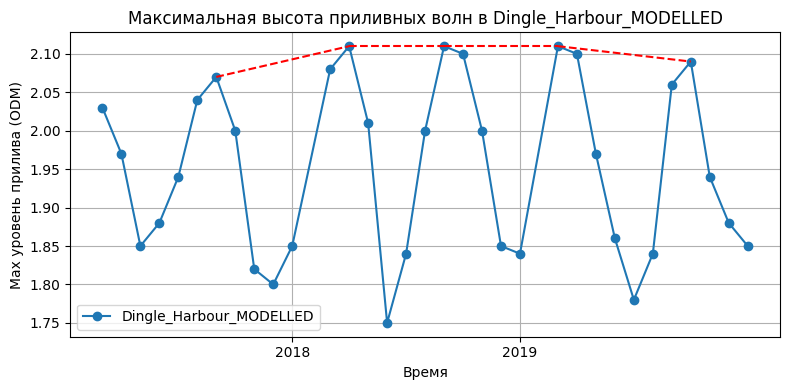

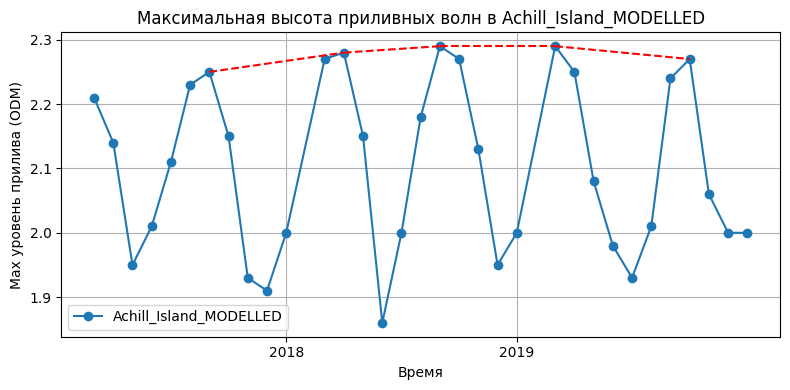

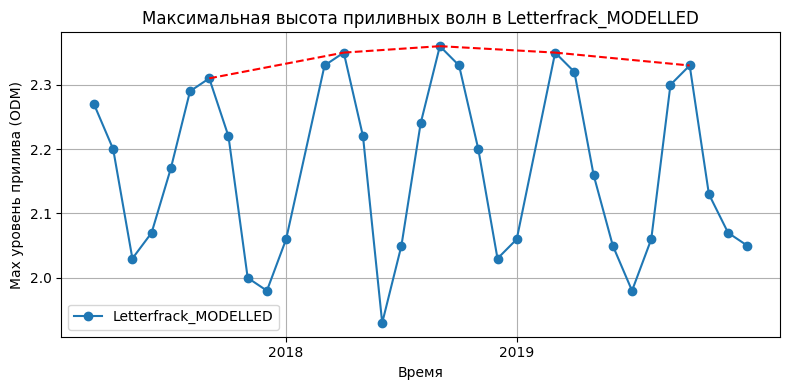

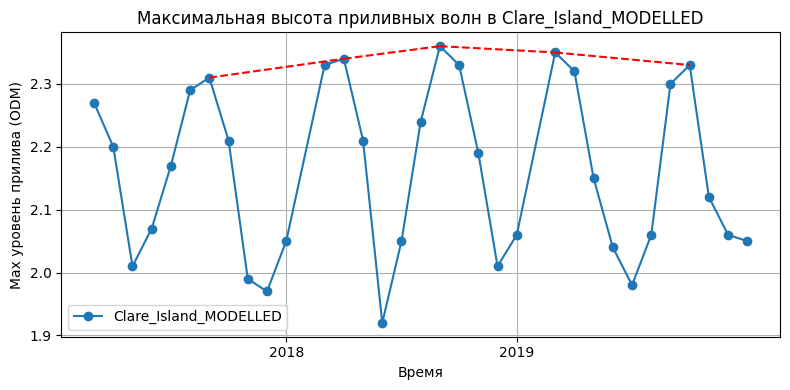

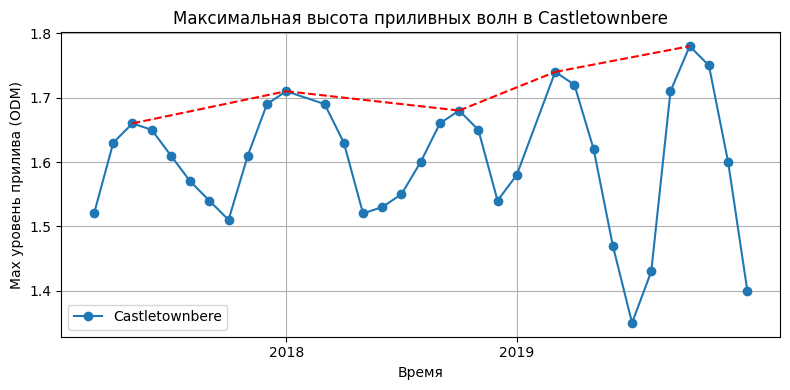

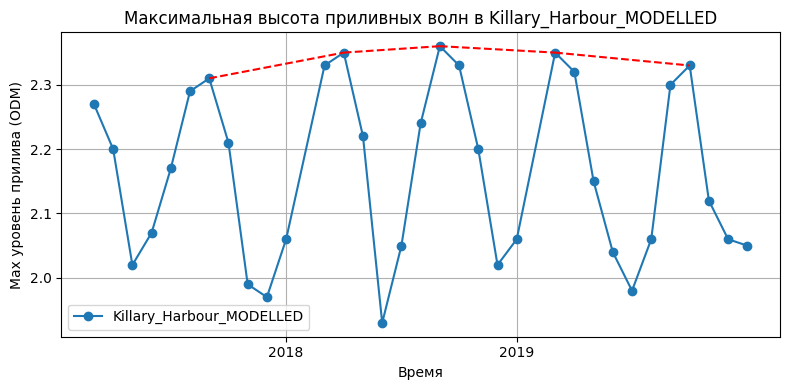

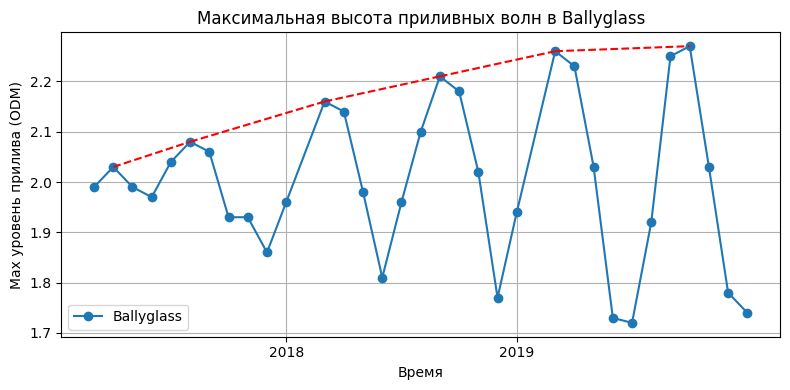

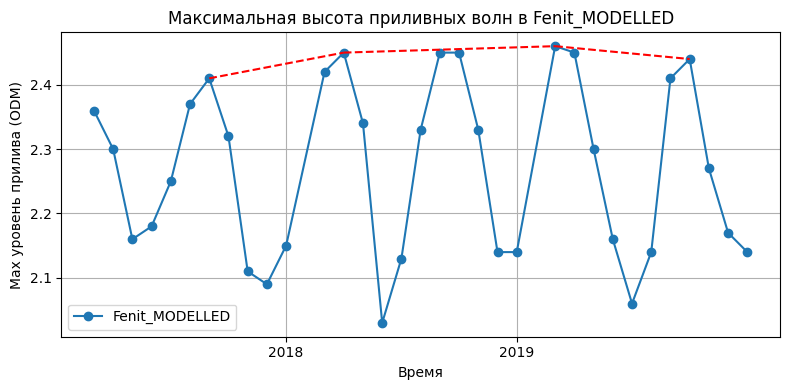

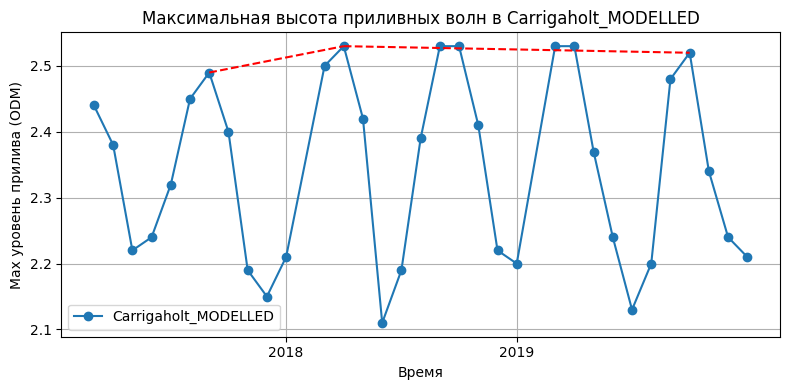

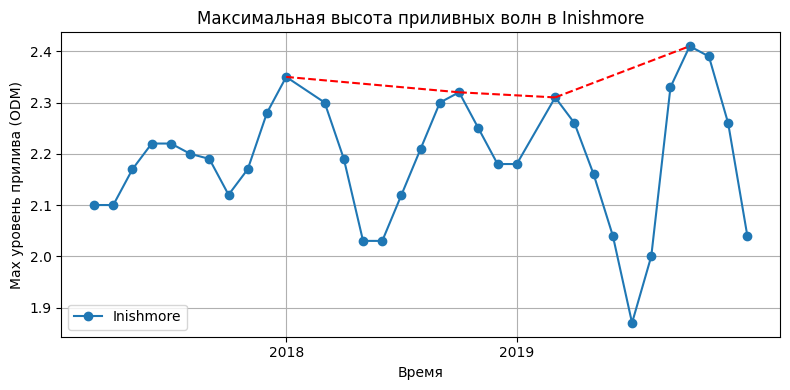

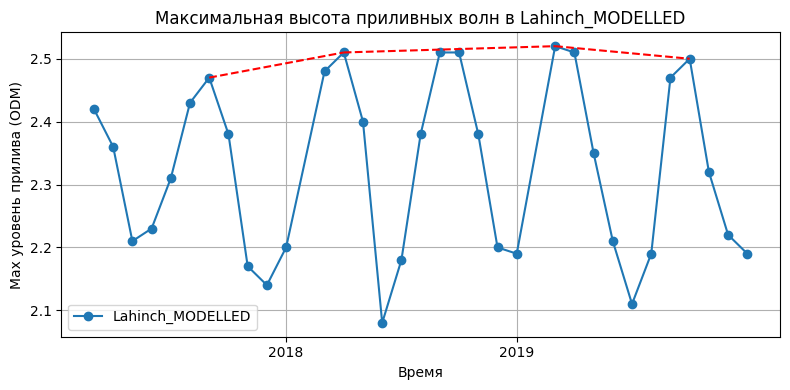

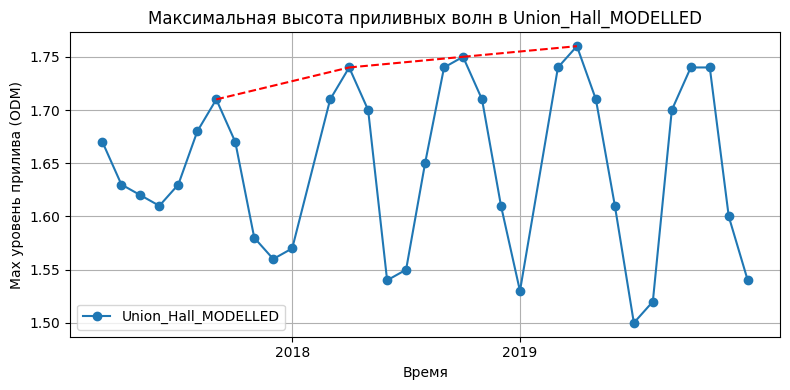

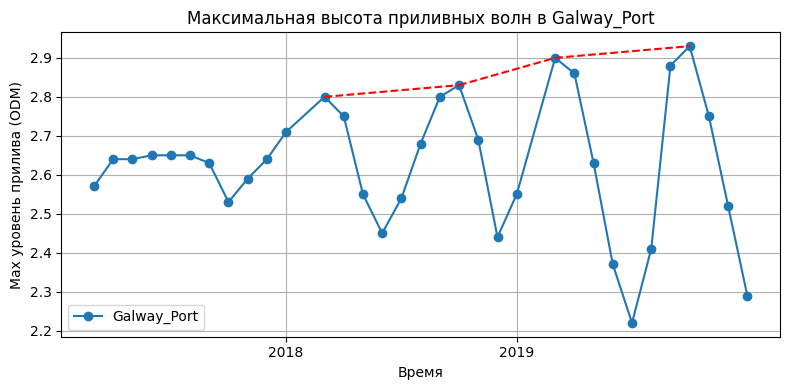

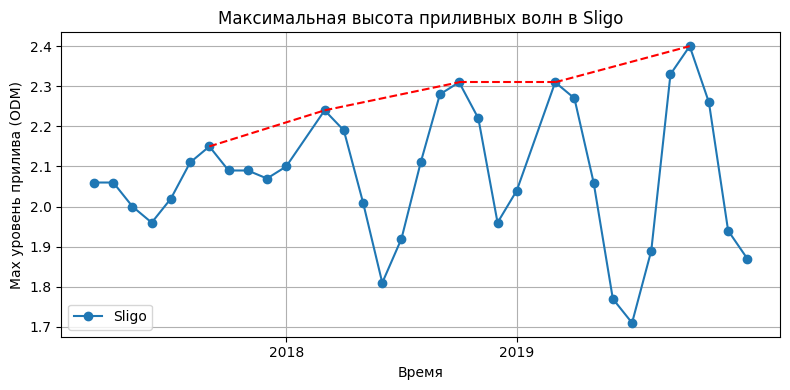

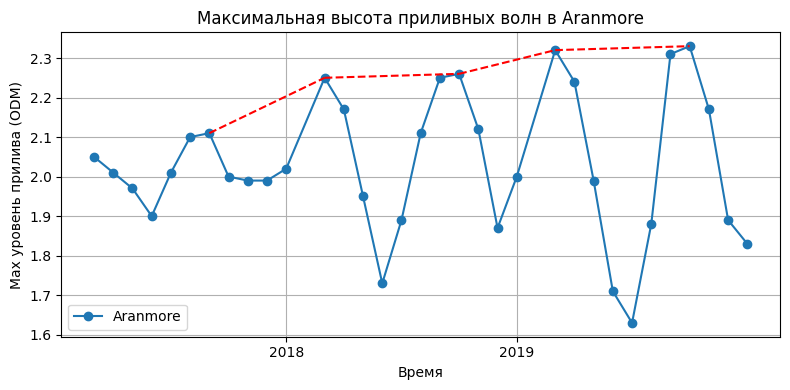

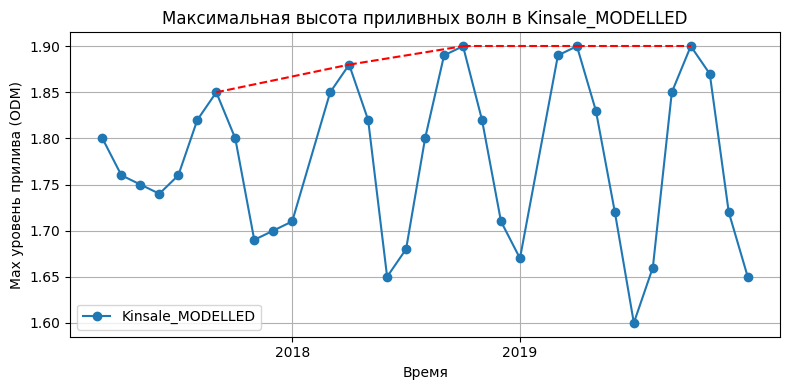

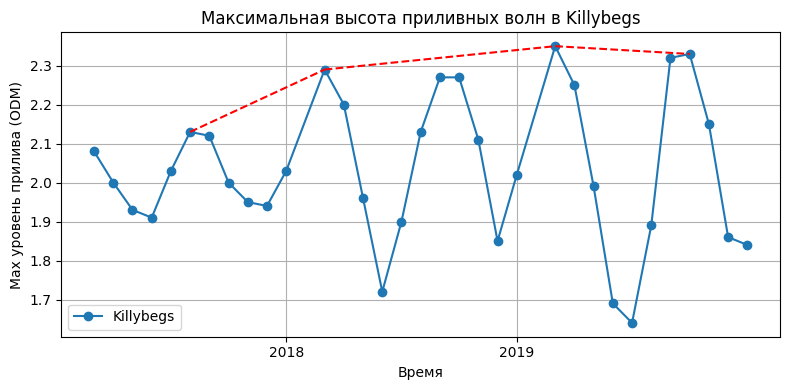

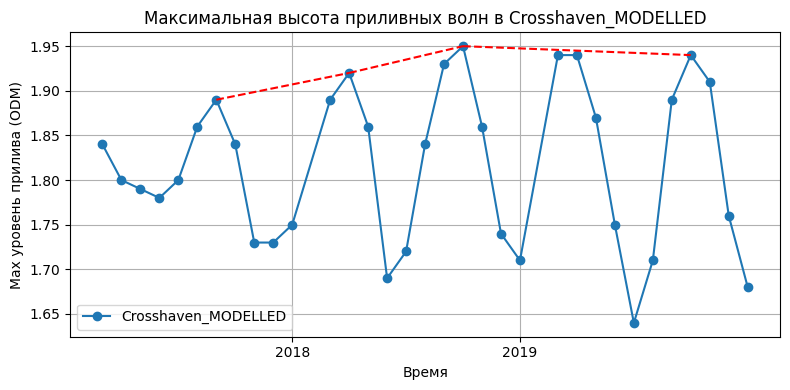

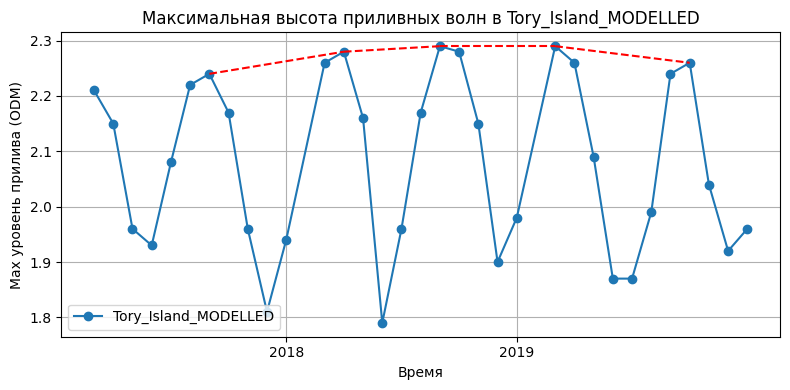

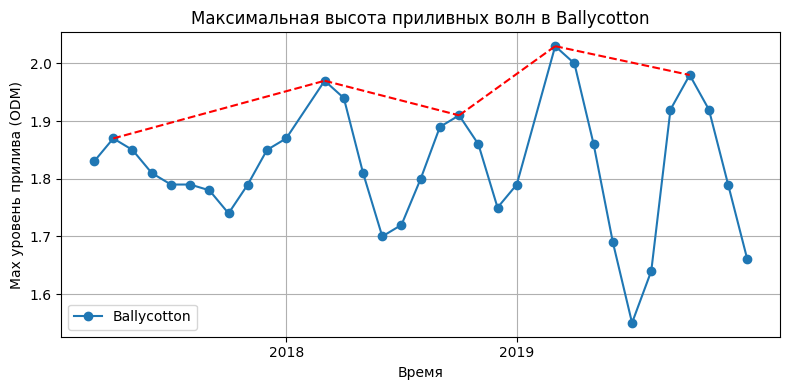

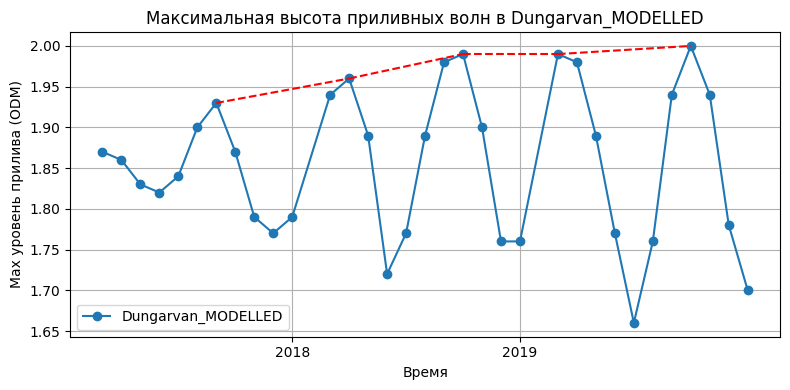

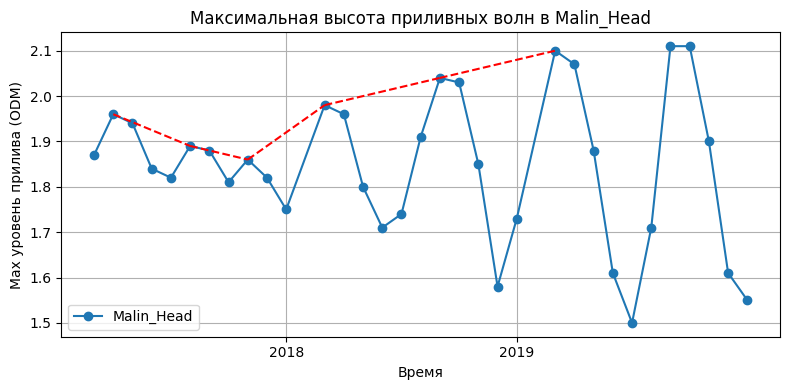

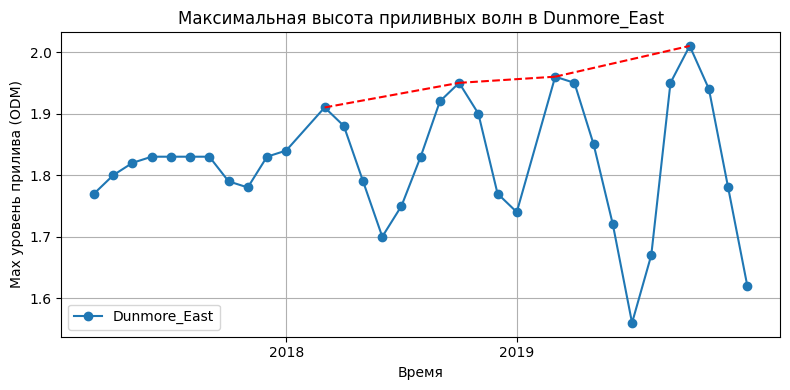

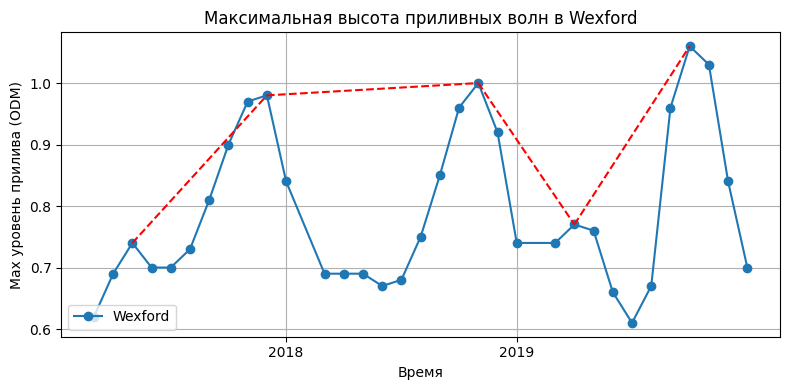

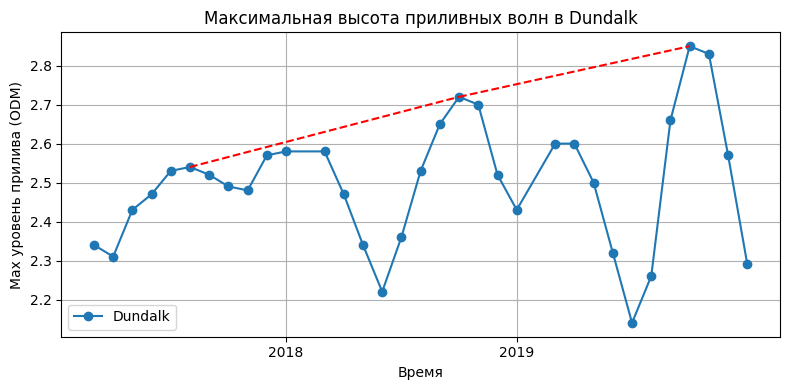

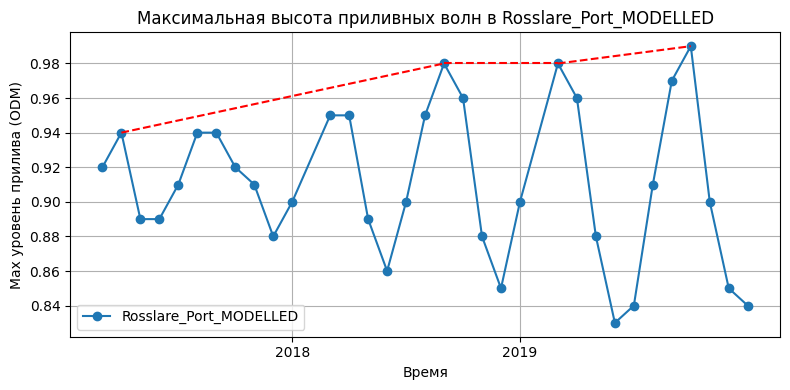

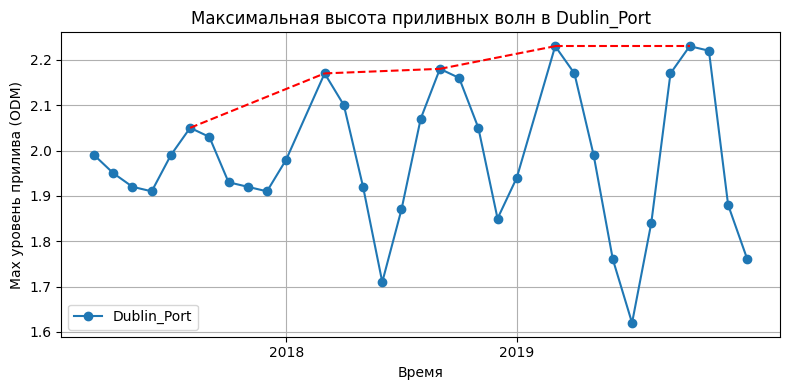

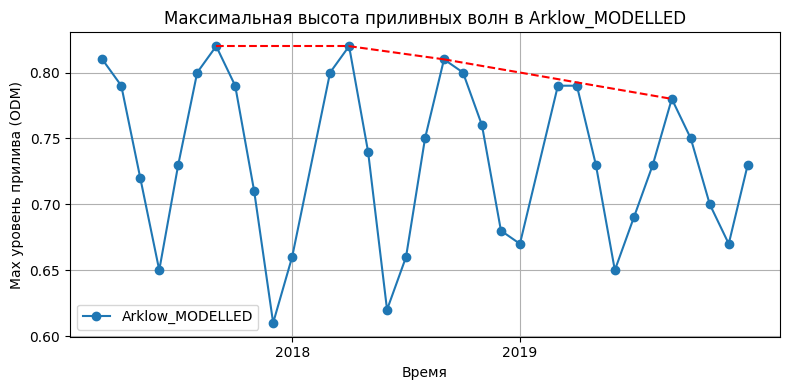

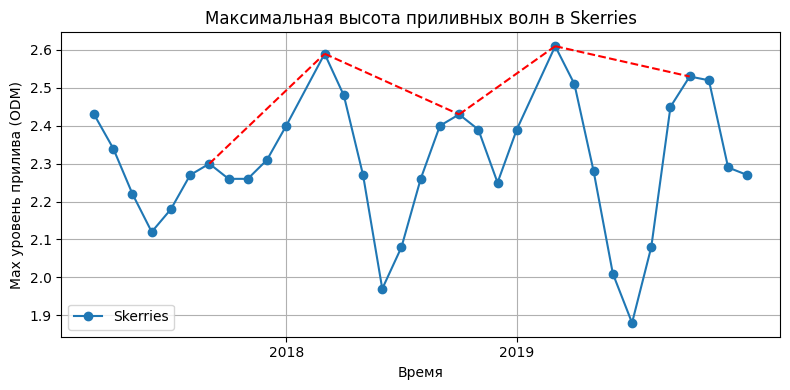

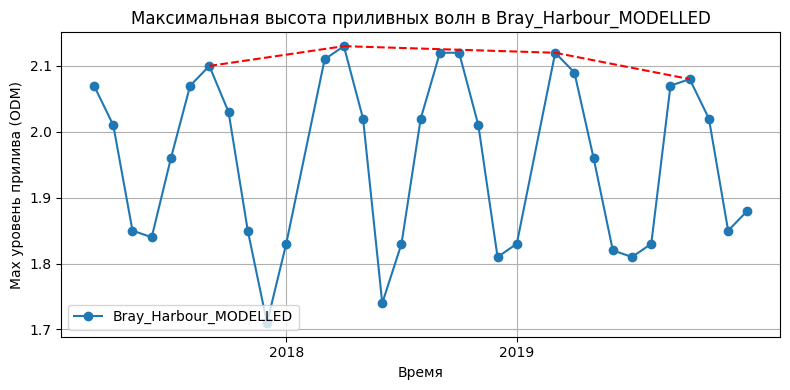

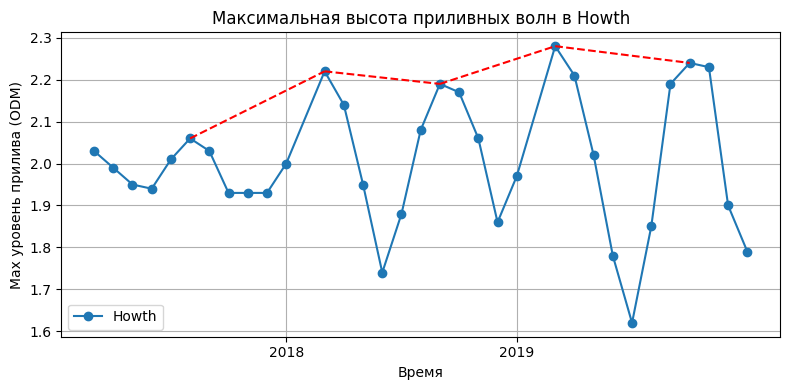

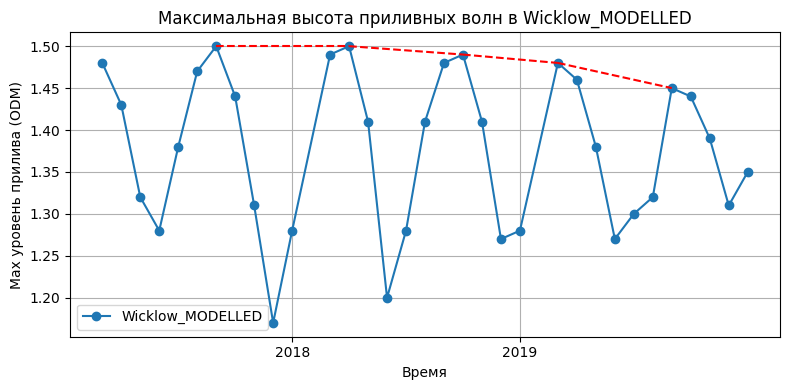

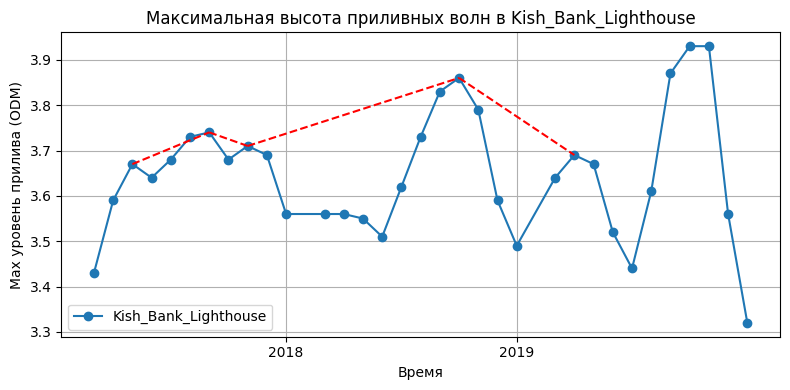

In [20]:
# Получим уникальные названия приливных станций
station_names = max_water_levels['station_id'].unique()

for station_name in station_names:
    # Фильтруем данные для текущей станции
    station_data = max_water_levels[max_water_levels['station_id'] == station_name]
    
    # Создаем график для приливной станции
    plt.figure(figsize=(8, 4))
    plt.plot(station_data['year'] + station_data['month'] / 12, station_data['max_water_level_odm'], marker='o', linestyle='-', label=station_name)
    plt.title(f'Максимальная высота приливных волн в {station_name}')
    plt.xlabel('Время')
    plt.ylabel('Max уровень прилива (ODM)')
    plt.xticks(np.arange(station_data['year'].min(), station_data['year'].max() + 1, 1))
    plt.legend(loc='lower left')
    plt.grid(True)
    
    # Найдем локальные максимумы
    local_maxima_indices = argrelextrema(station_data['max_water_level_odm'].values, np.greater)[0]
    
    # Построим касательные линии от одного максимума до другого
    for i in range(len(local_maxima_indices) - 1):
        x1 = station_data.iloc[local_maxima_indices[i]]['year'] + station_data.iloc[local_maxima_indices[i]]['month'] / 12
        x2 = station_data.iloc[local_maxima_indices[i + 1]]['year'] + station_data.iloc[local_maxima_indices[i + 1]]['month'] / 12
        y1 = station_data.iloc[local_maxima_indices[i]]['max_water_level_odm']
        y2 = station_data.iloc[local_maxima_indices[i + 1]]['max_water_level_odm']
        plt.plot([x1, x2], [y1, y2], linestyle='--', color='red')
    
    # Отобразим график
    plt.tight_layout()
    plt.show()

#### Промежуточный вывод:

1. Стабильность высоты приливных волн: Для 15 приливных станций, где максимальная высота приливных волн либо осталась стабильной, либо показала незначительное уменьшение во второй половине 2019 года, можно предположить, что климатические и геологические условия в этих регионах в значительной степени остались неизменными: Dingle_Harbour_MODELLE, Achill_Island_MODELLED, Letterfrack_MODELLED, Clare_Island_MODELLED, Killary_Harbour_MODELLED, Fenit_MODELLED, Carrigaholt_MODELLED, Lahinch_MODELLED, Union_Hall_MODELLED, Kinsale_MODELLED, Killybegs, Crosshaven_MODELLED, Tory_Island_MODELLED, Bray_Harbour_MODELLED, Howth

2. Увеличение высоты приливных волн: На 12 приливных станциях наблюдается увеличение максимальной высоты приливных волн. Это может указывать на потенциальные изменения в климатических условиях или на воздействие геологических факторов, которые усиливают приливы. Эта информация может помочь регионам в разработке более надежных систем защиты от наводнений и адаптации к изменениям в уровне моря: Castletownbere, Ballyglass, Inishmore, Galway_Port, Sligo, Aranmore, Dungarvan_MODELLED, Malin_Head, Dunmore_East, Dundalk, Rosslare_Port_MODELLED, Dublin_Port

3. Колебания высоты приливных волн: Для 4 приливных станций, где наблюдаются сильные колебания максимальной высоты приливных волн, важно отметить, что эти регионы могут быть подвержены более сложным гидродинамическим процессам или другим факторам, которые могут привести к непредсказуемым изменениям. Это может потребовать дополнительных исследований и мониторинга для понимания этих колебаний: Ballycotton, Wexford, Skerries, Kish_Bank_Lighthouse

4. Уменьшение высоты приливных волн: Для 2 приливных станций, где наблюдается уменьшение максимальной высоты приливных волн, это может быть следствием различных факторов, включая геологические изменения или изменения в приливных потоках: Arklow_MODELLED, Wicklow_MODELLED

<a name="5."></a>
## Вывод
<font size="2">([к содержанию](#0.0))</font>

1. **Амплитуда приливных волн:** В данных было обнаружено, что амплитуда приливных волн сильно варьирует в разных регионах. Существует 6 станций с амплитудой более 5 метров и 19 станций с амплитудой около 4 метров. Эти высокие амплитуды приливов создают потенциально опасные условия для навигации в портах и прибрежных водах.
2. **Географические различия:** Географический анализ показывает, что наибольшие амплитуды приливных волн наблюдаются на западном побережье острова Ирландия, особенно вокруг графства Голуэй. Также высокие амплитуды приливных волн можно наблюдать в Дублине и на северном побережье. В то время как регионы на юге острова, такие как Корк и Уотерфорд, характеризуются более низкими амплитудами.
3. **Тенденции в изменении высоты приливных волн:** Анализ временных данных показывает различные тенденции. Некоторые станции демонстрируют стабильность или небольшое уменьшение высоты приливных волн, в то время как другие станции отмечают ее увеличение. Эти изменения могут быть связаны с климатическими и геологическими факторами и могут иметь важное значение для понимания долгосрочных тенденций и разработки мер по адаптации и защите прибрежных регионов.
4. **Потенциал для приливной энергетики:** Регионы с высокими амплитудами приливных волн, такие как Голуэй и северное побережье, предоставляют потенциал для использования приливной энергии. Приливные электростанции могут быть эффективными в этих местах благодаря колебаниям уровня воды, что может способствовать развитию возобновляемых источников энергии.

В целом, анализ приливных данных подчеркивает важность мониторинга и понимания приливных процессов для обеспечения безопасности навигации, разработки эффективных систем защиты от наводнений и оптимизации использования приливной энергии в разных регионах острова Ирландия.